# Comparison between empirical and predicted pipeline similarities

In [1]:
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

wd = "/mnt/hpc_work/"
#wd = "/gss/work/zead9360/"

file_paths = [f"{wd}/GCN-pipelines/multiverse/multiverse_pipelines/results/universe_{i}.pkl" for i in range(1, 15)]
gcn_data = f"{wd}/GCN-pipelines/Data/graph_and_embeddings.pkl"
pipeline_path = f"{wd}/GCN-pipelines/Data/pipelines_multiverse.xlsx"

The empirical similarity is estimated for 14 different pipelines as defined in the multiverse analysis in `mverse.py`:

In [2]:
universes_data = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        universe = pickle.load(file)
        universes_data.append(list(universe.values()))

empirical_similarity = np.corrcoef(np.array(universes_data))

Data from the trained GCN network is loaded:

In [19]:
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]

# Load pipelines and trained embeddings
pipeline_df = pd.read_excel(pipeline_path, index_col=0)
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}

Estimated pipeline dissimilarity from GCN predictions with DTW:

In [20]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)  # Use mean sequence as reference
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# Joint embeddings with dynamic time warping
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embeddings_dict[node] for node in pipeline if node in embeddings_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw)

dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

Other measures:

In [21]:
# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Plotting of pairwise similarity and correlation between emprical and predicted:

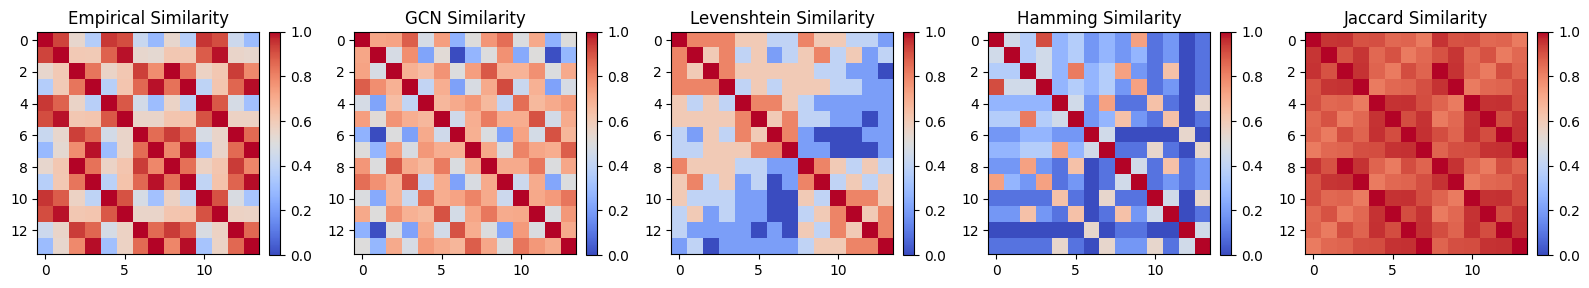

Spearman correlation:
 [[1.         0.03956044 0.0118137  0.10652897 0.30481695]
 [0.03956044 1.         0.22247372 0.58354865 0.43914021]
 [0.0118137  0.22247372 1.         0.44391564 0.15510247]
 [0.10652897 0.58354865 0.44391564 1.         0.0881447 ]
 [0.30481695 0.43914021 0.15510247 0.0881447  1.        ]]


In [22]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

vmin = 0
vmax = 1

im0 = ax[0].imshow(empirical_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[0].set_title('Empirical Similarity')
cbar0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)  # Adjust colorbar height

im1 = ax[1].imshow(embedding_similarity_dtw, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[1].set_title('GCN Similarity')
cbar1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(levenshtein_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[2].set_title('Levenshtein Similarity')
cbar2 = fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(hamming_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[3].set_title('Hamming Similarity')
cbar3 = fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

im4 = ax[4].imshow(jaccard_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[4].set_title('Jaccard Similarity')
cbar4 = fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

empirical_upper = empirical_similarity[np.triu_indices_from(empirical_similarity, k=1)]
gcn_upper = embedding_similarity_dtw[np.triu_indices_from(embedding_similarity_dtw, k=1)]
levenshtein_upper = levenshtein_similarity[np.triu_indices_from(levenshtein_similarity, k=1)]
hamming_upper = hamming_similarity[np.triu_indices_from(hamming_similarity, k=1)]
jaccard_upper = jaccard_similarity[np.triu_indices_from(jaccard_similarity, k=1)]

similarity_data = pd.DataFrame({
    'Empirical': empirical_upper,
    'GCN': gcn_upper,
    'Levenshtein': levenshtein_upper,
    'Hamming': hamming_upper,
    'Jaccard': jaccard_upper
})

spearman_corr = spearmanr(similarity_data)[0]
print("Spearman correlation:\n", spearman_corr)
